Human Activity Recognition using WISDM dataset

https://www.cis.fordham.edu/wisdm/dataset.php
Team Members - Lakshmi Umarale, Srinivas Reddy, Shreya Suriya

Goal-

There are six activities-
We plan to use the WISDM dataset for training, validation and testing.
We will also collect the sensor tile data for all the activities and test them against the trained models.

Project Workflow-

Loading of the accelerometer data from the WISDM data set Convert and reformat accelerometer data into a time-sliced representation (convert into segments) Exploratory Data Analysis on the data set Visualize the accelerometer data Reshape the multi-dimensional data so that it is accepted by Keras Split up the data set into training, validation, and test set - (Better Splitting Approach in our case, is to split based on the user IDs. We will keep users with ID 1 to 28 for training the model and users with ID greater than 28 for the test set.)

Define a deep neural network model in Keras Train the deep neural network for human activity recognition data Validate the performance of the trained DNN against the test data using learning curve and confusion matrix Save the model (save the weights)

Define a Convolutional Neural Network using TensorFlow Train the convolutional neural network for human activity recognition data Validate the performance of the trained CNN against the test data using learning curve and confusion matrix Save the model (save the weights)

Define a LSTM neural network Train the LSTM neural network for human activity recognition data Validate the performance of the trained LSTM against the test data using learning curve and confusion matrix Save the model (save the weights)

EdgeImpulse- Collect the data from the sensor tile and train the data in EdgeImpulse Use Transfer Learning and validate the performance

Followed the same Machine Learning Workflow as illustrated by Nils Ackerman in the diagram below in the next cell

References - https://towardsdatascience.com/human-activity-recognition-har-tutorial-with-keras-and-core-ml-part-1-8c05e365dfa0



In [1]:
#Libraries to be imported
from __future__ import print_function
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
#import coremltools
from scipy import stats
from IPython.display import display, HTML

from sklearn import metrics
from sklearn.metrics import classification_report, accuracy_score
from sklearn import preprocessing

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Reshape, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import LSTM


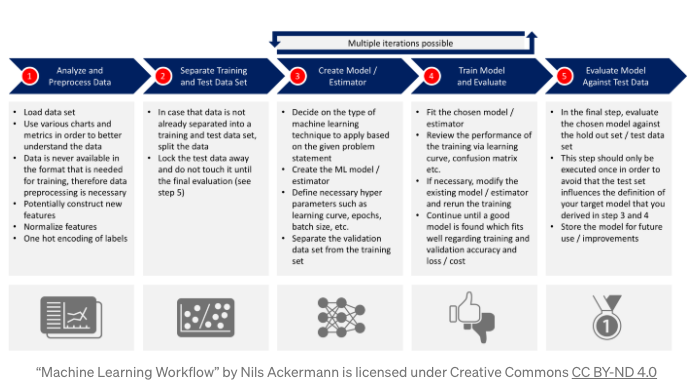

In [2]:
from IPython.display import Image
Image(filename='Process.png')

In [3]:
pd.options.display.float_format = '{:.1f}'.format
sns.set() # Default seaborn look and feel
plt.style.use('ggplot')

# Same labels will be reused throughout the program
LABELS = ['Downstairs',
          'Jogging',
          'Sitting',
          'Standing',
          'Upstairs',
          'Walking']
# The number of steps within one time segment
TIME_PERIODS = 80
# The steps to take from one segment to the next; if this value is equal to
# TIME_PERIODS, then there is no overlap between the segments

STEP_DISTANCE = 40

In [4]:
#Some helper functions to read the data 
def read_data(file_path):

    column_names = ['user-id',
                    'activity',
                    'timestamp',
                    'x-axis',
                    'y-axis',
                    'z-axis']
    
    #Read the csv file 
    df = pd.read_csv(file_path,
                     header=None,
                     names=column_names)
    # Last column has a ";" character which must be removed ...
    df['z-axis'].replace(regex=True,
      inplace=True,
      to_replace=r';',
      value=r'')
    # ... and then this column must be transformed to float explicitly
    df['z-axis'] = df['z-axis'].apply(convert_to_float)
    
    # This is very important otherwise the model will not fit and loss
    # will show up as NAN
    df.dropna(axis=0, how='any', inplace=True)

    return df

def convert_to_float(x):

    try:
        return np.float(x)
    except:
        return np.nan
 
def show_basic_dataframe_info(dataframe):

    # Shape and how many rows and columns
    print('Number of columns in the dataframe: %i' % (dataframe.shape[1]))
    print('Number of rows in the dataframe: %i\n' % (dataframe.shape[0]))
    print(dataframe.info())

# Load data set containing all the data from csv
df = read_data('WISDM_ar_v1.1_raw.txt')

In [5]:
# Describe the data
show_basic_dataframe_info(df)
df.head(20)

Number of columns in the dataframe: 6
Number of rows in the dataframe: 1098203

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1098203 entries, 0 to 1098203
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   user-id    1098203 non-null  int64  
 1   activity   1098203 non-null  object 
 2   timestamp  1098203 non-null  int64  
 3   x-axis     1098203 non-null  float64
 4   y-axis     1098203 non-null  float64
 5   z-axis     1098203 non-null  float64
dtypes: float64(3), int64(2), object(1)
memory usage: 58.7+ MB
None


,user-id,activity,timestamp,x-axis,y-axis,z-axis
0,33,Jogging,49105962326000,-0.7,12.7,0.5
1,33,Jogging,49106062271000,5.0,11.3,1.0
2,33,Jogging,49106112167000,4.9,10.9,-0.1
3,33,Jogging,49106222305000,-0.6,18.5,3.0
4,33,Jogging,49106332290000,-1.2,12.1,7.2
5,33,Jogging,49106442306000,1.4,-2.5,-6.5
6,33,Jogging,49106542312000,-0.6,10.6,5.7
7,33,Jogging,49106652389000,-0.5,13.9,7.1
8,33,Jogging,49106762313000,-8.4,11.4,5.1
9,33,Jogging,49106872299000,1.0,1.4,1.6


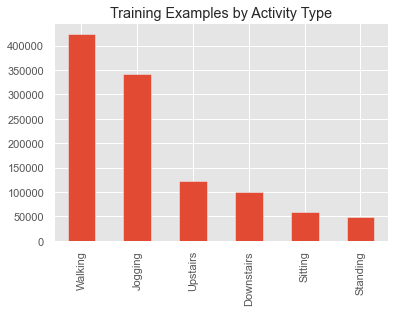

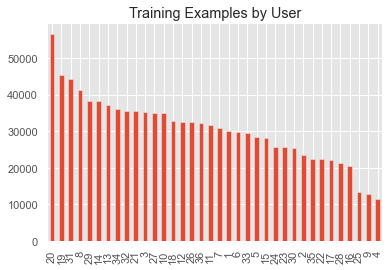

In [6]:
#Visualization
# Show how many training examples exist for each of the six activities
df['activity'].value_counts().plot(kind='bar',
                                   title='Training Examples by Activity Type')
plt.show()

# Better understand how the recordings are spread across the different
# users who participated in the study
df['user-id'].value_counts().plot(kind='bar',
                                  title='Training Examples by User')
plt.show()


Number of examples: 1,098,203
Number of attributes: 6
Missing attribute values: None
Class Distribution
Walking: 424,400 (38.6%)
Jogging: 342,177 (31.2%)
Upstairs: 122,869 (11.2%)
Downstairs: 100,427 (9.1%)
Sitting: 59,939 (5.5%)
Standing: 48,395 (4.4%)

Exploratory Data Analysis of the Data Set-

As we can see, we have more data for walking and jogging activities than we have for the other activities. Also we can see that 36 persons have participated in the experiment.
Next, let’s take a look at the accelerometer data for each of the three axis for all six possible activities. The data is recorded at a sampling rate of 20 Hz (20 values per second). Since we show the first 180 records, each chart shows a 9 second interval for each of the six activities (calculation: 0.05 * 180 = 9 seconds). We will use two functions (which I have borrowed from here) to plot the data.

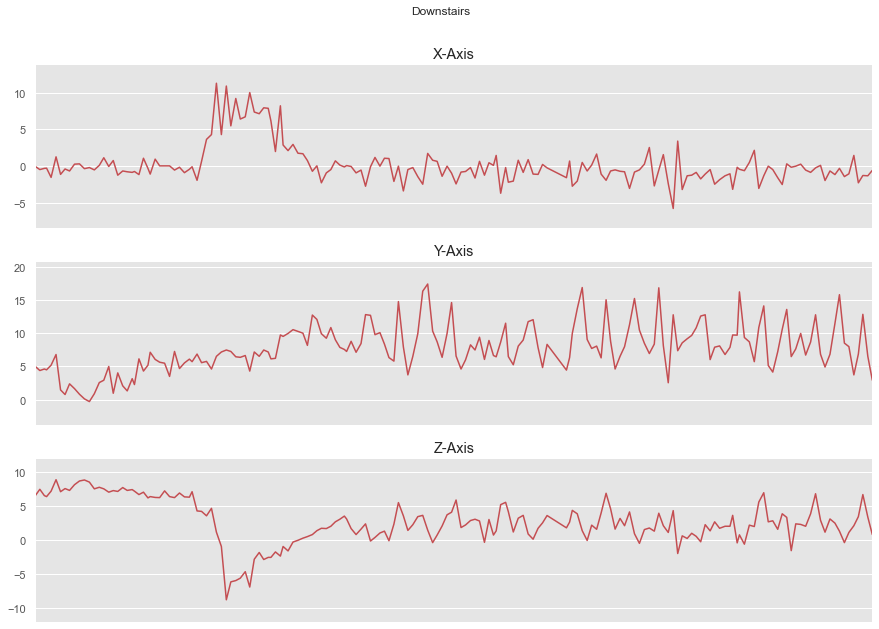

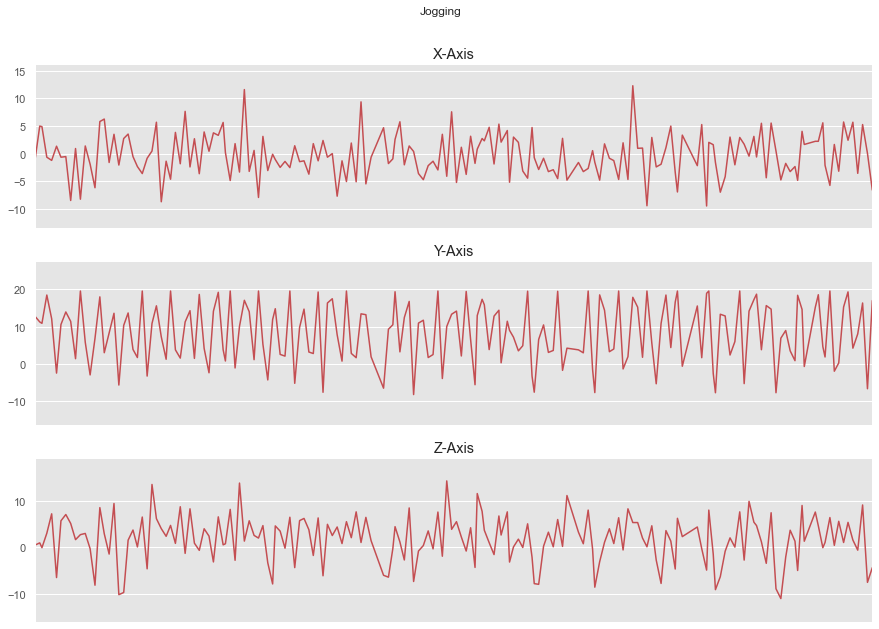

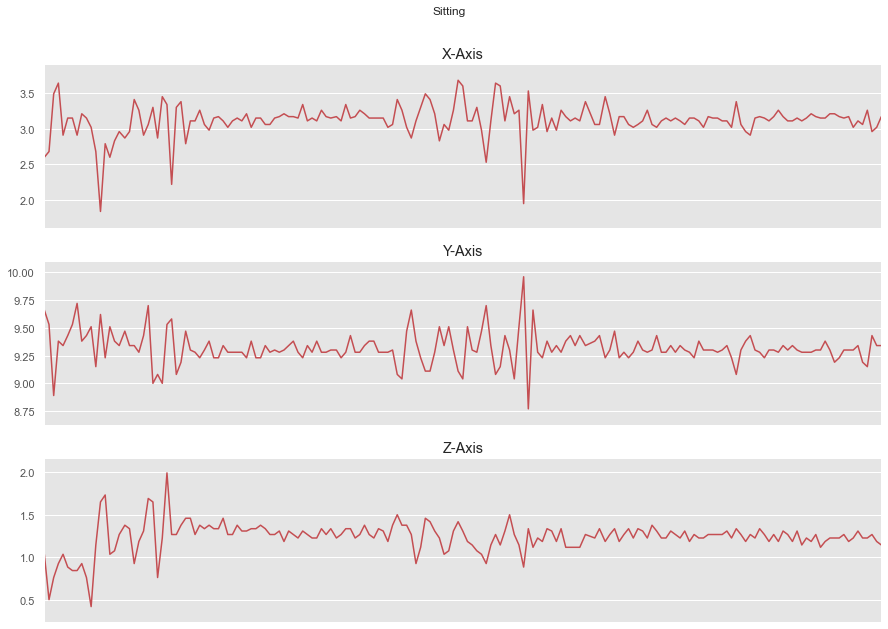

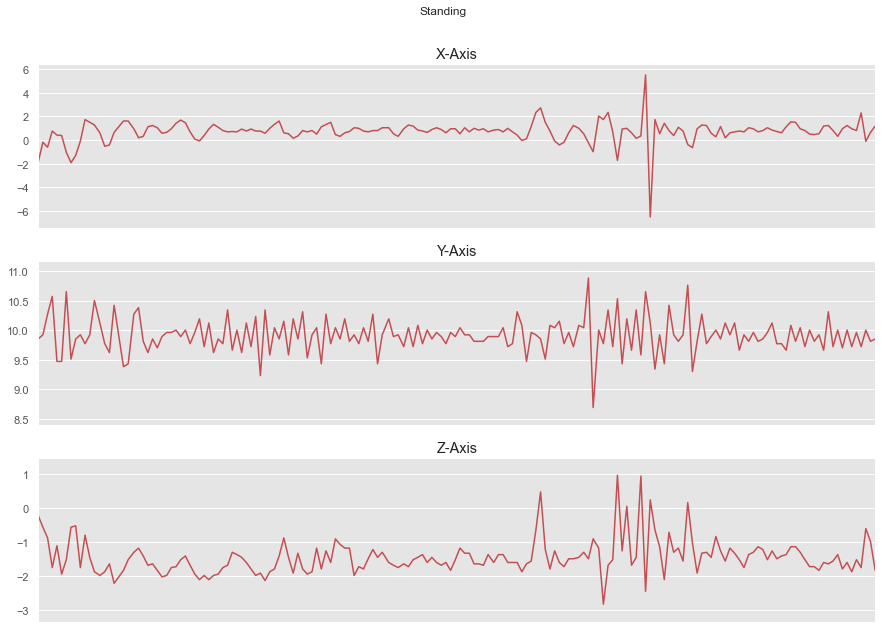

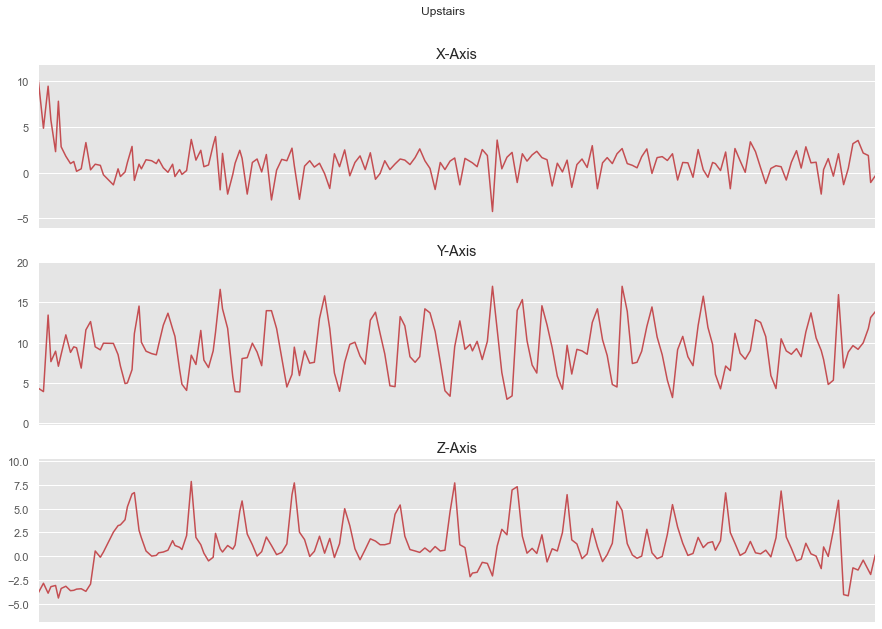

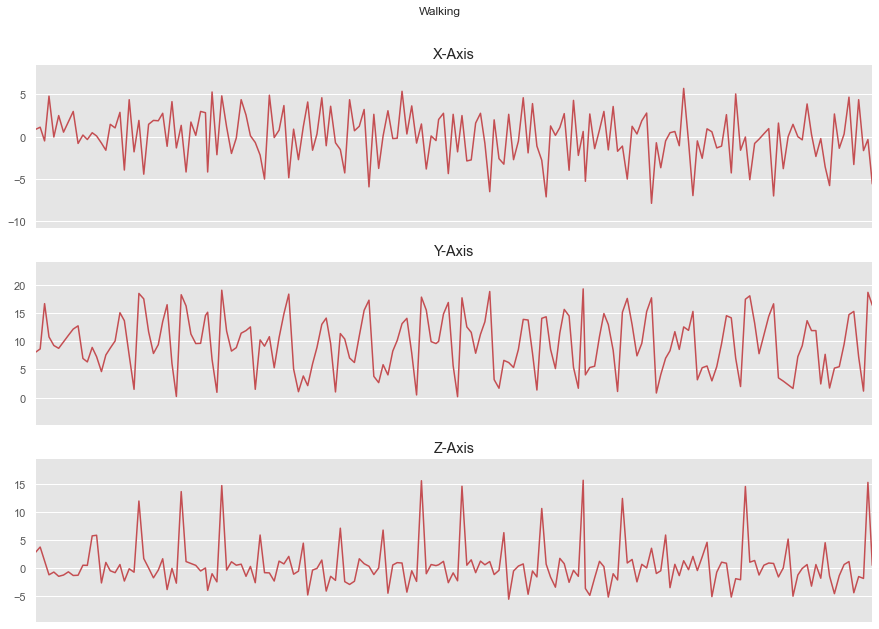

In [7]:
def plot_activity(activity, data):

    fig, (ax0, ax1, ax2) = plt.subplots(nrows=3,
         figsize=(15, 10),
         sharex=True)
    plot_axis(ax0, data['timestamp'], data['x-axis'], 'X-Axis')
    plot_axis(ax1, data['timestamp'], data['y-axis'], 'Y-Axis')
    plot_axis(ax2, data['timestamp'], data['z-axis'], 'Z-Axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.90)
    plt.show()

def plot_axis(ax, x, y, title):

    ax.plot(x, y, 'r')
    ax.set_title(title)
    ax.xaxis.set_visible(False)
    ax.set_ylim([min(y) - np.std(y), max(y) + np.std(y)])
    ax.set_xlim([min(x), max(x)])
    ax.grid(True)

for activity in np.unique(df['activity']):
    subset = df[df['activity'] == activity][:180]
    plot_activity(activity, subset)

As expected, there is a higher acceleration for activities such as jogging and walking compared to sitting. Before we continue, we will add one more column with the name “ActivityEncoded” to the dataframe with the encoded value for each activity: Downstairs, Jogging, Sitting, Standing, Upstairs, Walking
This is needed since the deep neural network cannot work with non-numerical labels. With the LabelEncoder, we are able to easily to convert back to the original label text.

In [8]:
# Define column name of the label vector
LABEL = 'ActivityEncoded'

# Transform the labels from String to Integer via LabelEncoder
le = preprocessing.LabelEncoder()

# Add a new column to the existing DataFrame with the encoded values
df[LABEL] = le.fit_transform(df['activity'].values.ravel())

In [9]:
df.head()

,user-id,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
0,33,Jogging,49105962326000,-0.7,12.7,0.5,1
1,33,Jogging,49106062271000,5.0,11.3,1.0,1
2,33,Jogging,49106112167000,4.9,10.9,-0.1,1
3,33,Jogging,49106222305000,-0.6,18.5,3.0,1
4,33,Jogging,49106332290000,-1.2,12.1,7.2,1


Split Data into Training and Test Set-

It is important to separate the whole data set into a training set and a test set. Often times, you see mistakes on how the data is split. However you decide to split the data, you never want information from the test set to bleed into your training set. This might be great for the overall performance of your model during training and then validation against the test set. But your model is very unlikely to generalize well for data it has not seen yet.
The idea behind splitting: We want our neural network to learn from a few persons which have been through the experiment. Next, we then want to see how well our neural network predicts the movements of persons it has not seen before.
Data Splitting to Avoid
Only worrying about having at least a few example records per activity is not sufficient. You will run the risk that you have maybe three records of activity “Walking” for person 5 in the training set and one record for activity “Walking” for person 5 in the test set. Of course, with this type of situation, your model will perform great because it has already seen the movement pattern of person 5 during training. Always be critical about the performance of your DNN — it might be because of the wrong data split in the first place.
Better Splitting Approach
In our case, let’s split based on the user IDs. We will keep users with ID 1 to 28 for training the model and users with ID greater than 28 for the test set.

In [10]:
# Differentiate between test set and training set
df_test = df[df['user-id'] > 28]
df_train = df[df['user-id'] <= 28]

Normalize Training Data-

Next, we need to normalize our features within our training data. Of course there are various ways on how to normalize. Please keep in mind that you use the same normalization algorithm later when feeding new data into your neural network. Otherwise your preditions will be off. On top of the normalization we will also apply rounding to the three features.

In [11]:
# Normalize features for training data set (values between 0 and 1)
# Surpress warning for next 3 operation
pd.options.mode.chained_assignment = None  # default='warn'
df_train['x-axis'] = df_train['x-axis'] / df_train['x-axis'].max()
df_train['y-axis'] = df_train['y-axis'] / df_train['y-axis'].max()
df_train['z-axis'] = df_train['z-axis'] / df_train['z-axis'].max()
# Round numbers
df_train = df_train.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

In [12]:
df_train.head()

,user-id,activity,timestamp,x-axis,y-axis,z-axis,ActivityEncoded
8489,17,Walking,57869902574000,0.0,0.5,-0.0,5
8490,17,Walking,57870012316000,-0.0,0.5,-0.0,5
8491,17,Walking,57870122301000,-0.0,0.5,-0.0,5
8492,17,Walking,57870222246000,0.0,0.5,-0.0,5
8493,17,Walking,57870332292000,0.0,0.5,-0.0,5


Reshape Data into Segments and Prepare for Keras-

The data contained in the dataframe is not ready yet to be fed into a neural network. Therefore we need to reshape it. Let’s create another function for this called “create_segments_and_labels”. This function will take in the dataframe and the label names (the constant that we have defined at the beginning) as well as the length of each record. In our case, let’s go with 80 steps (see constant defined earlier). Taking into consideration the 20 Hz sampling rate, this equals to 4 second time intervals (calculation: 0.05 * 80 = 4). Besides reshaping the data, the function will also separate the features (x-acceleration, y-acceleration, z-acceleration) and the labels (associated activity).

In [13]:
def create_segments_and_labels(df, time_steps, step, label_name):

    # x, y, z acceleration as features
    N_FEATURES = 3
    
    # Number of steps to advance in each iteration (for me, it should always
    # be equal to the time_steps in order to have no overlap between segments)
    # step = time_steps
    segments = []
    labels = []
    
    for i in range(0, len(df) - time_steps, step):
        xs = df['x-axis'].values[i: i + time_steps]
        ys = df['y-axis'].values[i: i + time_steps]
        zs = df['z-axis'].values[i: i + time_steps]
        
        # Retrieve the most often used label in this segment
        label = stats.mode(df[label_name][i: i + time_steps])[0][0]
        segments.append([xs, ys, zs])
        labels.append(label)

    # Bring the segments into a better shape, rows unknown, so we give input as -1
    reshaped_segments = np.asarray(segments, dtype= np.float32).reshape(-1, time_steps, N_FEATURES)
    labels = np.asarray(labels)

    return reshaped_segments, labels

x_train, y_train = create_segments_and_labels(df_train,
                                              TIME_PERIODS,
                                              STEP_DISTANCE,
                                              LABEL)

By now, you should have both 20.868 records in x_train as well as in y_train. Each of the 20.868 records in x_train is a two dimensional matrix of the shape 80x3. Reshape returns an array containing the same data with a new shape.

In [14]:
print('x_train shape: ', x_train.shape)
print(x_train.shape[0], 'training samples')
print('y_train shape: ', y_train.shape)

x_train shape:  (20868, 80, 3)
20868 training samples
y_train shape:  (20868,)


For constructing our deep neural network, we should now store the following dimensions:

Number of time periods: This is the number of time periods within one record (since we wanted to have a 4 second time interval, this number is 80 in our case)

Number of sensors: This is 3 since we only use the acceleration over the x, y, and z axis

Number of classes: This is the amount of nodes for our output layer in the neural network. Since we want our neural network to predict the type of activity, we will take the number of classes from the encoder that we have used earlier.

In [15]:
# Set input & output dimensions
num_time_periods, num_sensors = x_train.shape[1], x_train.shape[2]
num_classes = le.classes_.size
print(list(le.classes_))

['Downstairs', 'Jogging', 'Sitting', 'Standing', 'Upstairs', 'Walking']


Before continuing, we need to convert all feature data (x_train) and label data (y_train) into a datatype accepted by Keras.

In [16]:
x_train = x_train.astype('float32')
y_train = y_train.astype('float32')

We are almost done with the preparation of our data. One last step we need to do is to conduct one-hot-encoding of our labels. Please only execute this line once!

In [17]:
from tensorflow.keras import utils

y_train_hot = utils.to_categorical(y_train, num_classes)
print('New y_train shape: ', y_train_hot.shape)

New y_train shape:  (20868, 6)


In [18]:
# Normalize features for test data set
df_test['x-axis'] = df_test['x-axis'] / df_test['x-axis'].max()
df_test['y-axis'] = df_test['y-axis'] / df_test['y-axis'].max()
df_test['z-axis'] = df_test['z-axis'] / df_test['z-axis'].max()

df_test = df_test.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

x_test, y_test = create_segments_and_labels(df_test,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

x_test = x_test.astype('float32')
y_test = y_test.astype('float32')

print('x_test shape: ', x_test.shape)
print(x_test.shape[0], 'test samples')
print('y_test shape: ', y_test.shape)

y_test_hot = utils.to_categorical(y_test, num_classes)

x_test shape:  (6584, 80, 3)
6584 test samples
y_test shape:  (6584,)


In [19]:
def show_confusion_matrix(validations, predictions):

    matrix = metrics.confusion_matrix(validations, predictions)
    plt.figure(figsize=(6, 4))
    sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=LABELS,
                yticklabels=LABELS,
                annot=True,
                fmt='d')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [20]:
def plot_accuracy_loss(history):
    plt.figure(figsize=(6, 4))
    plt.plot(history.history['accuracy'], 'r', label='Accuracy of training data')
    plt.plot(history.history['val_accuracy'], 'b', label='Accuracy of validation data')
    plt.plot(history.history['loss'], 'r--', label='Loss of training data')
    plt.plot(history.history['val_loss'], 'b--', label='Loss of validation data')
    plt.title('Model Accuracy and Loss')
    plt.ylabel('Accuracy and Loss')
    plt.xlabel('Training Epoch')
    plt.ylim(0)
    plt.legend()
    plt.show()

In [21]:
def summarize_results(score, model_name="DNN"):
    print('\nAccuracy on test data for %s model : %0.2f' % (model_name, score[1]))
    print('\nLoss on test data for %s model : %0.2f' % (model_name, score[0]))

In [22]:
from numpy.random import seed
from tensorflow.random import set_seed
from tensorflow.keras.optimizers import Adam

seed(14)
set_seed(14)

In [124]:
def run_model1(trainX, trainy, testX, testy):
    
    # Hyper-parameters
    verbose, epochs, batch_size = 1, 100, 400
    
    input_shape = (num_time_periods*num_sensors)
    
    # Set input_shape / reshape for Keras
    trainX = trainX.reshape(trainX.shape[0], input_shape)
    testX = testX.reshape(testX.shape[0], input_shape)
    
    callbacks_list = [
    tensorflow.keras.callbacks.ModelCheckpoint(
        filepath='best_model1.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    tensorflow.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)
    ]
    
    model = Sequential()
    model.add(Reshape((TIME_PERIODS, num_sensors), input_shape=(input_shape,)))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))
    model.add(Flatten())
    model.add(Dense(num_classes, activation='softmax'))
    print(model.summary())
    
    #Compile and Fit the Model
    #model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

    #callbacks=callbacks_list,
    # Enable validation to use ModelCheckpoint and EarlyStopping callbacks.
    history = model.fit(trainX,
                      trainy,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_split = 0.2,
                      callbacks=callbacks_list,
                      verbose=verbose)
                  
    #Plot the accuracy/loss
    plot_accuracy_loss(history)
    
    #Evaluate the model
    score = model.evaluate(testX, testy, verbose=verbose)
    summarize_results(score, "DNN")    
    
    y_pred_test = model.predict(testX)

    # Take the class with the highest probability from the test predictions
    max_y_pred_test = np.argmax(y_pred_test, axis=1)
    max_y_test = np.argmax(testy, axis=1)

    show_confusion_matrix(max_y_test, max_y_pred_test)

    print(classification_report(max_y_test, max_y_pred_test, target_names=LABELS))

    
    return score, model              
                  

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_5 (Reshape)          (None, 80, 3)             0         
_________________________________________________________________
dense_29 (Dense)             (None, 80, 100)           400       
_________________________________________________________________
dense_30 (Dense)             (None, 80, 100)           10100     
_________________________________________________________________
dense_31 (Dense)             (None, 80, 100)           10100     
_________________________________________________________________
dense_32 (Dense)             (None, 80, 100)           10100     
_________________________________________________________________
flatten_7 (Flatten)          (None, 8000)              0         
_________________________________________________________________
dense_33 (Dense)             (None, 6)                

42/42 [==============================] - 2s 53ms/step - loss: 0.1141 - accuracy: 0.9606 - val_loss: 1.4519 - val_accuracy: 0.6759
Epoch 50/100
42/42 [==============================] - 2s 53ms/step - loss: 0.1087 - accuracy: 0.9622 - val_loss: 1.3421 - val_accuracy: 0.7233
Epoch 51/100
42/42 [==============================] - 2s 51ms/step - loss: 0.1101 - accuracy: 0.9619 - val_loss: 1.6386 - val_accuracy: 0.6610
Epoch 52/100
42/42 [==============================] - 2s 53ms/step - loss: 0.1056 - accuracy: 0.9638 - val_loss: 1.3968 - val_accuracy: 0.7163
Epoch 53/100
42/42 [==============================] - 2s 53ms/step - loss: 0.1000 - accuracy: 0.9662 - val_loss: 1.6215 - val_accuracy: 0.6878
Epoch 54/100
42/42 [==============================] - 2s 55ms/step - loss: 0.1104 - accuracy: 0.9596 - val_loss: 1.6383 - val_accuracy: 0.6730
Epoch 55/100
42/42 [==============================] - 2s 57ms/step - loss: 0.0925 - accuracy: 0.9702 - val_loss: 1.5546 - val_accuracy: 0.6974
Epoch 56/100

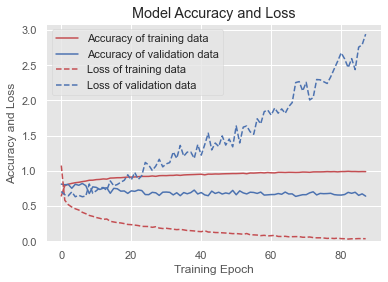

206/206 [==============================] - 1s 2ms/step - loss: 3.7142 - accuracy: 0.7454

Accuracy on test data for DNN model : 0.75

Loss on test data for DNN model : 3.71


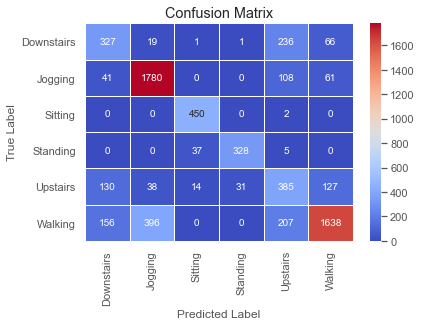

              precision    recall  f1-score   support

  Downstairs       0.50      0.50      0.50       650
     Jogging       0.80      0.89      0.84      1990
     Sitting       0.90      1.00      0.94       452
    Standing       0.91      0.89      0.90       370
    Upstairs       0.41      0.53      0.46       725
     Walking       0.87      0.68      0.76      2397

    accuracy                           0.75      6584
   macro avg       0.73      0.75      0.74      6584
weighted avg       0.76      0.75      0.75      6584



In [125]:
score1, model1 = run_model1(x_train, y_train_hot, x_test, y_test_hot)

In [25]:
def run_model21(trainX, trainy, testX, testy):
    
    verbose, epochs, batch_size = 1, 100, 64
    
    callbacks_list = [
    tensorflow.keras.callbacks.ModelCheckpoint(
        filepath='best_model2.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    tensorflow.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)
        ]
    
    trainX = trainX.reshape(trainX.shape[0], num_time_periods, num_sensors, 1)
    testX  = testX.reshape(testX.shape[0], num_time_periods, num_sensors, 1)
    
    model = Sequential()
    model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = trainX[0].shape))
    model.add(Dropout(0.1))

    #model.add(BatchNormalization())

    model.add(Conv2D(32, (2, 2), activation='relu'))
    model.add(Dropout(0.2))

    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.2))

    model.add(Flatten())

    model.add(Dense(128, activation = 'relu'))
    model.add(Dropout(0.5))

    model.add(Dense(num_classes, activation='softmax'))
    
    
    print(model.summary())
    
    model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
    
    history = model.fit(trainX, trainy, epochs = epochs, validation_data= (testX, testy), callbacks=callbacks_list, verbose=verbose)

    #Plot the accuracy/loss
    plot_accuracy_loss(history)
    
    #Evaluate the model
    score = model.evaluate(testX, testy, verbose=verbose)
    summarize_results(score, "CNN")    
    
    y_pred_test = model.predict(testX)

    # Take the class with the highest probability from the test predictions
    max_y_pred_test = np.argmax(y_pred_test, axis=1)
    max_y_test = np.argmax(testy, axis=1)

    show_confusion_matrix(max_y_test, max_y_pred_test)

    print(classification_report(max_y_test, max_y_pred_test, target_names=LABELS))

    
    return score, model 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 79, 2, 16)         80        
_________________________________________________________________
dropout (Dropout)            (None, 79, 2, 16)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 78, 1, 32)         2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 78, 1, 32)         0         
_________________________________________________________________
dense_4 (Dense)              (None, 78, 1, 64)         2112      
_________________________________________________________________
dropout_2 (Dropout)          (None, 78, 1, 64)         0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 4992)             

653/653 [==============================] - 4s 7ms/step - loss: 0.0818 - accuracy: 0.9701 - val_loss: 4.0382 - val_accuracy: 0.8439
Epoch 47/100
653/653 [==============================] - 4s 7ms/step - loss: 0.0791 - accuracy: 0.9718 - val_loss: 3.5009 - val_accuracy: 0.8461
Epoch 48/100
653/653 [==============================] - 4s 6ms/step - loss: 0.0764 - accuracy: 0.9726 - val_loss: 2.7450 - val_accuracy: 0.8363
Epoch 49/100
653/653 [==============================] - 4s 6ms/step - loss: 0.0775 - accuracy: 0.9702 - val_loss: 3.7114 - val_accuracy: 0.8414
Epoch 50/100
653/653 [==============================] - 4s 6ms/step - loss: 0.0768 - accuracy: 0.9711 - val_loss: 3.5996 - val_accuracy: 0.8466
Epoch 51/100
653/653 [==============================] - 4s 6ms/step - loss: 0.0729 - accuracy: 0.9731 - val_loss: 3.4385 - val_accuracy: 0.8534
Epoch 52/100
653/653 [==============================] - 4s 6ms/step - loss: 0.0724 - accuracy: 0.9728 - val_loss: 3.8045 - val_accuracy: 0.8507
Epoch

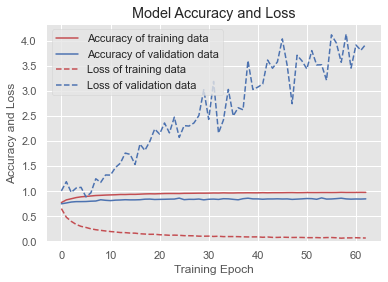

206/206 [==============================] - 0s 1ms/step - loss: 3.9310 - accuracy: 0.8466

Accuracy on test data for CNN model : 0.85

Loss on test data for CNN model : 3.93


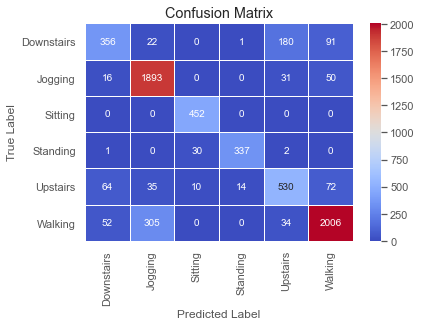

              precision    recall  f1-score   support

  Downstairs       0.73      0.55      0.63       650
     Jogging       0.84      0.95      0.89      1990
     Sitting       0.92      1.00      0.96       452
    Standing       0.96      0.91      0.93       370
    Upstairs       0.68      0.73      0.71       725
     Walking       0.90      0.84      0.87      2397

    accuracy                           0.85      6584
   macro avg       0.84      0.83      0.83      6584
weighted avg       0.85      0.85      0.84      6584



In [26]:
score21, model21 = run_model21(x_train, y_train_hot, x_test, y_test_hot)

In [27]:
def run_model2(trainX, trainy, testX, testy):
    
    verbose, epochs, batch_size = 1, 100, 64
    
    callbacks_list = [
    tensorflow.keras.callbacks.ModelCheckpoint(
        filepath='best_model2.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    tensorflow.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)
        ]
    
    trainX = trainX.reshape(trainX.shape[0], num_time_periods, num_sensors, 1)
    testX  = testX.reshape(testX.shape[0], num_time_periods, num_sensors, 1)
    
    
    model = Sequential()
    model.add(Conv2D(16, (2, 2), activation = 'relu', input_shape = trainX[0].shape))
    model.add(Dropout(0.1))

    model.add(Conv2D(32, (2, 2), activation='relu'))
    model.add(Dropout(0.2))

    model.add(Flatten())

    model.add(Dense(64, activation = 'relu'))
    model.add(Dropout(0.5))

    model.add(Dense(6, activation='softmax'))
    print(model.summary())
    
    model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])
    
    history = model.fit(trainX, trainy, epochs = epochs, validation_split=0.2, callbacks=callbacks_list, verbose=verbose)

    #Plot the accuracy/loss
    plot_accuracy_loss(history)
    
    #Evaluate the model
    score = model.evaluate(testX, testy, verbose=verbose)
    summarize_results(score, "CNN")    
    
    y_pred_test = model.predict(testX)

    # Take the class with the highest probability from the test predictions
    max_y_pred_test = np.argmax(y_pred_test, axis=1)
    max_y_test = np.argmax(testy, axis=1)

    show_confusion_matrix(max_y_test, max_y_pred_test)

    print(classification_report(max_y_test, max_y_pred_test, target_names=LABELS))

    
    return score, model 

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 79, 2, 16)         80        
_________________________________________________________________
dropout_4 (Dropout)          (None, 79, 2, 16)         0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 78, 1, 32)         2080      
_________________________________________________________________
dropout_5 (Dropout)          (None, 78, 1, 32)         0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2496)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 64)                159808    
_________________________________________________________________
dropout_6 (Dropout)          (None, 64)               

522/522 [==============================] - 2s 4ms/step - loss: 0.0979 - accuracy: 0.9621 - val_loss: 0.8981 - val_accuracy: 0.8047
Epoch 49/100
522/522 [==============================] - 2s 4ms/step - loss: 0.1004 - accuracy: 0.9602 - val_loss: 0.7926 - val_accuracy: 0.8165
Epoch 50/100
522/522 [==============================] - 2s 4ms/step - loss: 0.0996 - accuracy: 0.9612 - val_loss: 0.9079 - val_accuracy: 0.8117
Epoch 51/100
522/522 [==============================] - 2s 4ms/step - loss: 0.0977 - accuracy: 0.9615 - val_loss: 0.8881 - val_accuracy: 0.7906
Epoch 52/100
522/522 [==============================] - 2s 4ms/step - loss: 0.0902 - accuracy: 0.9651 - val_loss: 0.9136 - val_accuracy: 0.7875
Epoch 53/100
522/522 [==============================] - 2s 3ms/step - loss: 0.0916 - accuracy: 0.9645 - val_loss: 0.9705 - val_accuracy: 0.7738
Epoch 54/100
522/522 [==============================] - 2s 4ms/step - loss: 0.0954 - accuracy: 0.9641 - val_loss: 0.8359 - val_accuracy: 0.8026
Epoch

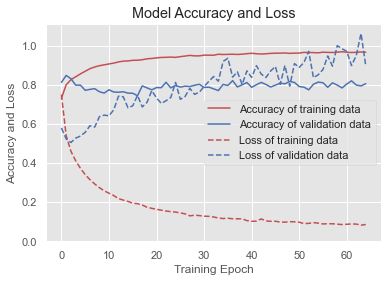

206/206 [==============================] - 0s 815us/step - loss: 3.9212 - accuracy: 0.8344

Accuracy on test data for CNN model : 0.83

Loss on test data for CNN model : 3.92


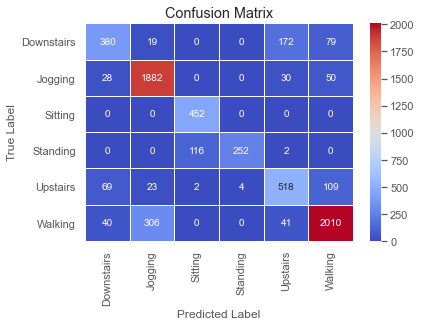

              precision    recall  f1-score   support

  Downstairs       0.74      0.58      0.65       650
     Jogging       0.84      0.95      0.89      1990
     Sitting       0.79      1.00      0.88       452
    Standing       0.98      0.68      0.81       370
    Upstairs       0.68      0.71      0.70       725
     Walking       0.89      0.84      0.87      2397

    accuracy                           0.83      6584
   macro avg       0.82      0.79      0.80      6584
weighted avg       0.84      0.83      0.83      6584



In [28]:
score2, model2 = run_model2(x_train, y_train_hot, x_test, y_test_hot)

In [29]:


def run_model3(trainX, trainy, testX, testy):
    
    verbose, epochs, batch_size = 1, 100, 64
    n_timesteps, n_features = trainX[0].shape[0], trainX[0].shape[1]
    callbacks_list = [
    tensorflow.keras.callbacks.ModelCheckpoint(
        filepath='best_model3.{epoch:02d}-{val_loss:.2f}.h5',
        monitor='val_loss', save_best_only=True),
    tensorflow.keras.callbacks.EarlyStopping(monitor='accuracy', patience=1)
    ]
    model = Sequential()
    model.add(LSTM(100, input_shape=(n_timesteps,n_features)))
    model.add(Dropout(0.5))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    print(model.summary())
    
    #Compile and Fit the Model
    #model.compile(optimizer=Adam(learning_rate = 0.001), loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    model.compile(loss='categorical_crossentropy',
                optimizer='adam', metrics=['accuracy'])

    history = model.fit(trainX, trainy, epochs = epochs, validation_data= (testX, testy), callbacks=callbacks_list, verbose=verbose)

    #Plot the accuracy/loss
    plot_accuracy_loss(history)
    
    #Evaluate the model
    score = model.evaluate(testX, testy, verbose=verbose)
    summarize_results(score, "LSTM")
    
    y_pred_test = model.predict(testX)

    # Take the class with the highest probability from the test predictions
    max_y_pred_test = np.argmax(y_pred_test, axis=1)
    max_y_test = np.argmax(testy, axis=1)

    show_confusion_matrix(max_y_test, max_y_pred_test)

    print(classification_report(max_y_test, max_y_pred_test, target_names=LABELS))
    
    return score, model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 100)               41600     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_10 (Dense)             (None, 6)                 606       
Total params: 52,306
Trainable params: 52,306
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/100
653/653 [==============================] - 16s 23ms/step - loss: 1.0754 - accuracy: 0.6364 - val_loss: 1.2284 - val_accuracy: 0.5481
Epoch 2/100
653/653 [==============================] - 14s 22ms/step - loss: 0.7982 - accuracy: 0.

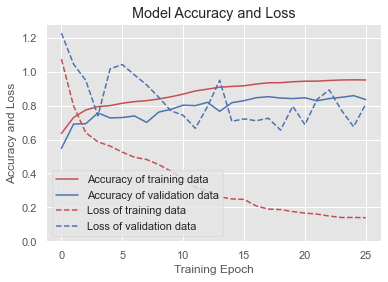

206/206 [==============================] - 1s 7ms/step - loss: 0.8103 - accuracy: 0.8358

Accuracy on test data for LSTM model : 0.84

Loss on test data for LSTM model : 0.81


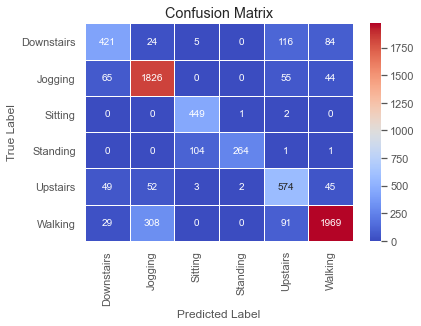

              precision    recall  f1-score   support

  Downstairs       0.75      0.65      0.69       650
     Jogging       0.83      0.92      0.87      1990
     Sitting       0.80      0.99      0.89       452
    Standing       0.99      0.71      0.83       370
    Upstairs       0.68      0.79      0.73       725
     Walking       0.92      0.82      0.87      2397

    accuracy                           0.84      6584
   macro avg       0.83      0.81      0.81      6584
weighted avg       0.84      0.84      0.84      6584



In [30]:
score3, model3 = run_model3(x_train, y_train_hot, x_test, y_test_hot)

In [31]:
#Print all the KPIs
datascore = {'Model Type': ['DNN', 'CNN', 'LSTM'], 'Model Accuracy Score': [score1[1], score2[1], score3[1]], 'Model Loss Score':[score1[0], score2[0], score3[0]]}
dfscore = pd.DataFrame(datascore)
print(dfscore)

  Model Type  Model Accuracy Score  Model Loss Score
0        DNN                   0.8               2.7
1        CNN                   0.8               3.9
2       LSTM                   0.8               0.8


Helper function to test the predictions against sample Data collected via the Sensor Tile is input and predictions are done

In [32]:
def read_and_parse_test_file(filepath, model, activityEncoder=0, modelType=1):
    df = pd.read_csv(filepath, skiprows=4)
    
    df.drop(['Date', 'NodeName', 'RawData', 'NodeTimestamp'], axis=1, inplace=True)
    df.dropna(axis=0, how='any', inplace=True)
    df.rename(columns = {'HostTimestamp': 'timestamp', 'X (mg)':'x-axis', 'Y (mg)':'y-axis', 'Z (mg)':'z-axis' }, inplace = True)
    df.insert(0, "user-id", 50) 
    df.insert(5, LABEL, activityEncoder)
    df['x-axis'] = df['x-axis'] / df['x-axis'].max()
    df['y-axis'] = df['y-axis'] / df['y-axis'].max()
    df['z-axis'] = df['z-axis'] / df['z-axis'].max()

    df = df.round({'x-axis': 4, 'y-axis': 4, 'z-axis': 4})

    x_test, y_test = create_segments_and_labels(df,
                                            TIME_PERIODS,
                                            STEP_DISTANCE,
                                            LABEL)

    # Set input_shape / reshape for Keras
    if modelType == 1:
        input_shape = (num_time_periods*num_sensors)
        x_test = x_test.reshape(x_test.shape[0], input_shape)
        print("Model : DNN")
    elif modelType == 2: 
        x_test = x_test.reshape(x_test.shape[0], num_time_periods, num_sensors, 1)
        print("Model : CNN")
    else:
        print("Model : LSTM")
    
        
    x_test = x_test.astype('float32')
    y_test = y_test.astype('float32')
    print('x_test shape: ', x_test.shape)
    print(x_test.shape[0], 'test samples')
    print('y_test shape: ', y_test.shape)
    
    
    y_pred_test = model.predict(x_test)
    
    # Take the class with the highest probability from the test predictions
    max_y_pred_test = np.argmax(y_pred_test, axis=1)
    
    
    y_test = utils.to_categorical(y_test, num_classes)
    max_y_test = np.argmax(y_test, axis=1) 
    
    accuracy = accuracy_score(max_y_test, max_y_pred_test)
    #accuracy = accuracy * 100.0
    print('\nAccuracy : %0.2f' % (accuracy))
    
    print(max_y_pred_test)
    print(max_y_test)
    for i in range(0, len(max_y_pred_test)):
        print(LABELS[max_y_pred_test[i]])
        
    #show_confusion_matrix(max_y_test1, max_y_pred_test1)
    print(classification_report(max_y_test, max_y_pred_test, zero_division=0))
    
    return accuracy

In [55]:
def plot_sensor_tile_data(filepath, activityEncoder=0):
    df = pd.read_csv(filepath, skiprows=4)
    
    df.drop(['Date', 'NodeName', 'RawData', 'NodeTimestamp'], axis=1, inplace=True)
    df.dropna(axis=0, how='any', inplace=True)
    df.rename(columns = {'HostTimestamp': 'timestamp', 'X (mg)':'x-axis', 'Y (mg)':'y-axis', 'Z (mg)':'z-axis' }, inplace = True)
    df.insert(0, "user-id", 50) 
    df.insert(5, LABEL, activityEncoder)
    plot_activity(LABELS[activityEncoder], df)

Testing of Jogging Activity against the different models from the sensor tile data

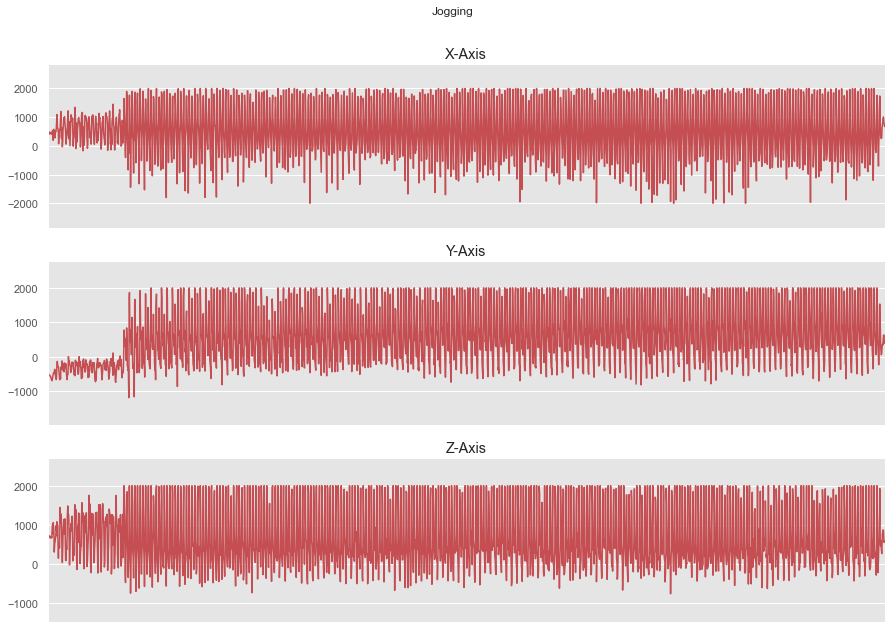

In [56]:
plot_sensor_tile_data("srinivas_jogging.csv", 1)

In [119]:
jogging_accuracy_model1 = read_and_parse_test_file('srinivas_jogging.csv', model1, 1)

Model : DNN
x_test shape:  (56, 240)
56 test samples
y_test shape:  (56,)

Accuracy : 0.29
[2 4 4 4 4 5 5 5 5 1 5 1 5 5 5 5 5 4 5 1 5 5 5 5 5 5 5 1 5 5 1 5 1 5 1 5 1
 5 5 5 1 1 1 5 1 5 1 5 1 5 5 1 5 4 1 5]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Sitting
Upstairs
Upstairs
Upstairs
Upstairs
Walking
Walking
Walking
Walking
Jogging
Walking
Jogging
Walking
Walking
Walking
Walking
Walking
Upstairs
Walking
Jogging
Walking
Walking
Walking
Walking
Walking
Walking
Walking
Jogging
Walking
Walking
Jogging
Walking
Jogging
Walking
Jogging
Walking
Jogging
Walking
Walking
Walking
Jogging
Jogging
Jogging
Walking
Jogging
Walking
Jogging
Walking
Jogging
Walking
Walking
Jogging
Walking
Upstairs
Jogging
Walking
              precision    recall  f1-score   support

           1       1.00      0.29      0.44        56
           2       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
        

In [75]:
jogging_accuracy_model2 = read_and_parse_test_file('srinivas_jogging.csv', model21, 1, 2)

Model : CNN
x_test shape:  (56, 80, 3, 1)
56 test samples
y_test shape:  (56,)

Accuracy : 0.93
[4 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Upstairs
Downstairs
Downstairs
Downstairs
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.93      0.96        56
           4       0.00      0.00      0.00         0

In [76]:
jogging_accuracy_model3 = read_and_parse_test_file('srinivas_jogging.csv', model3, 1, 3)

Model : LSTM
x_test shape:  (56, 80, 3)
56 test samples
y_test shape:  (56,)

Accuracy : 0.93
[5 5 5 5 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
Walking
Walking
Walking
Walking
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
              precision    recall  f1-score   support

           1       1.00      0.93      0.96        56
           5       0.00      0.00      0.00         0

    accuracy                           0.93        56
   macro a

Testing of Sitting Activity against the different models

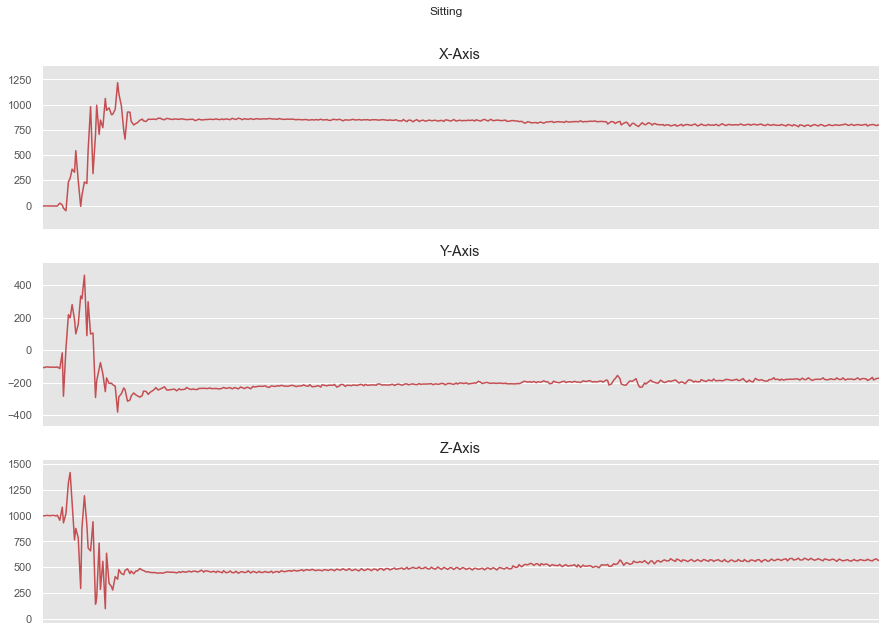

In [120]:
plot_sensor_tile_data("lakshmi_sitting.csv", 2)

In [121]:
sitting_accuracy_model1 = read_and_parse_test_file('lakshmi_sitting.csv', model1, 2)

Model : DNN
x_test shape:  (9, 240)
9 test samples
y_test shape:  (9,)

Accuracy : 0.11
[1 1 1 1 1 1 1 1 2]
[2 2 2 2 2 2 2 2 2]
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Jogging
Sitting
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       1.00      0.11      0.20         9

    accuracy                           0.11         9
   macro avg       0.50      0.06      0.10         9
weighted avg       1.00      0.11      0.20         9



In [37]:
sitting_accuracy_model2 = read_and_parse_test_file('lakshmi_sitting.csv', model21, 2, 2)

Model : CNN
x_test shape:  (9, 80, 3, 1)
9 test samples
y_test shape:  (9,)

Accuracy : 1.00
[2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2]
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         9

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



In [38]:
sitting_accuracy_model3 = read_and_parse_test_file('lakshmi_sitting.csv', model3, 2, 3)

Model : LSTM
x_test shape:  (9, 80, 3)
9 test samples
y_test shape:  (9,)

Accuracy : 1.00
[2 2 2 2 2 2 2 2 2]
[2 2 2 2 2 2 2 2 2]
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
Sitting
              precision    recall  f1-score   support

           2       1.00      1.00      1.00         9

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



Testing of Walking Upstairs Activity against the different models

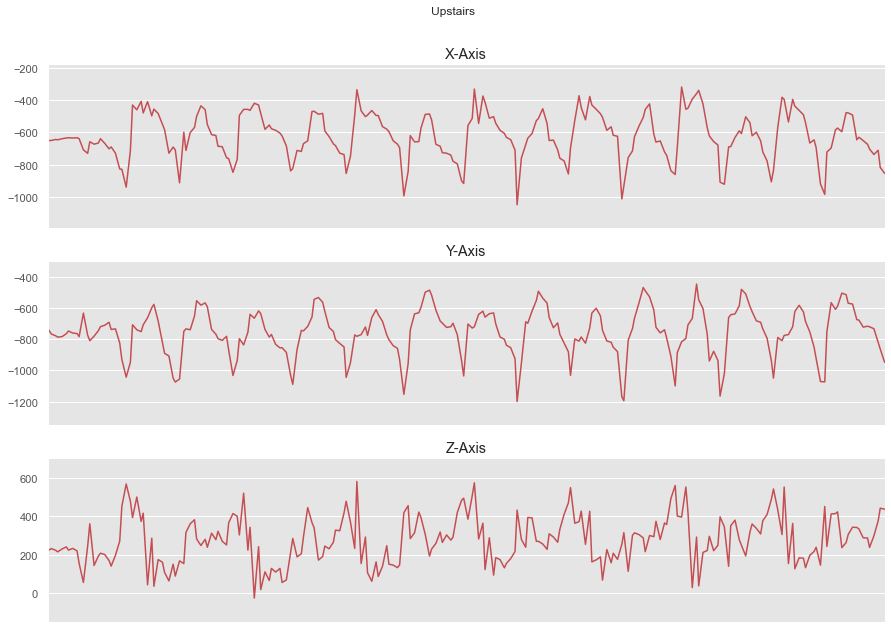

In [58]:
plot_sensor_tile_data("srinivas_upstairs10.csv", 4)

In [122]:
upstairs_accuracy_model1 = read_and_parse_test_file('srinivas_upstairs10.csv', model1, 4)

Model : DNN
x_test shape:  (4, 240)
4 test samples
y_test shape:  (4,)

Accuracy : 0.00
[5 5 5 5]
[4 4 4 4]
Walking
Walking
Walking
Walking
              precision    recall  f1-score   support

           4       0.00      0.00      0.00       4.0
           5       0.00      0.00      0.00       0.0

    accuracy                           0.00       4.0
   macro avg       0.00      0.00      0.00       4.0
weighted avg       0.00      0.00      0.00       4.0



In [40]:
upstairs_accuracy_model2 = read_and_parse_test_file('srinivas_upstairs10.csv', model21, 4, 2)

Model : CNN
x_test shape:  (4, 80, 3, 1)
4 test samples
y_test shape:  (4,)

Accuracy : 0.75
[4 4 4 5]
[4 4 4 4]
Upstairs
Upstairs
Upstairs
Walking
              precision    recall  f1-score   support

           4       1.00      0.75      0.86         4
           5       0.00      0.00      0.00         0

    accuracy                           0.75         4
   macro avg       0.50      0.38      0.43         4
weighted avg       1.00      0.75      0.86         4



In [41]:
upstairs_accuracy_model3 = read_and_parse_test_file('srinivas_upstairs10.csv', model3, 4, 3)

Model : LSTM
x_test shape:  (4, 80, 3)
4 test samples
y_test shape:  (4,)

Accuracy : 1.00
[4 4 4 4]
[4 4 4 4]
Upstairs
Upstairs
Upstairs
Upstairs
              precision    recall  f1-score   support

           4       1.00      1.00      1.00         4

    accuracy                           1.00         4
   macro avg       1.00      1.00      1.00         4
weighted avg       1.00      1.00      1.00         4



Testing of walking downstairs activity using different models

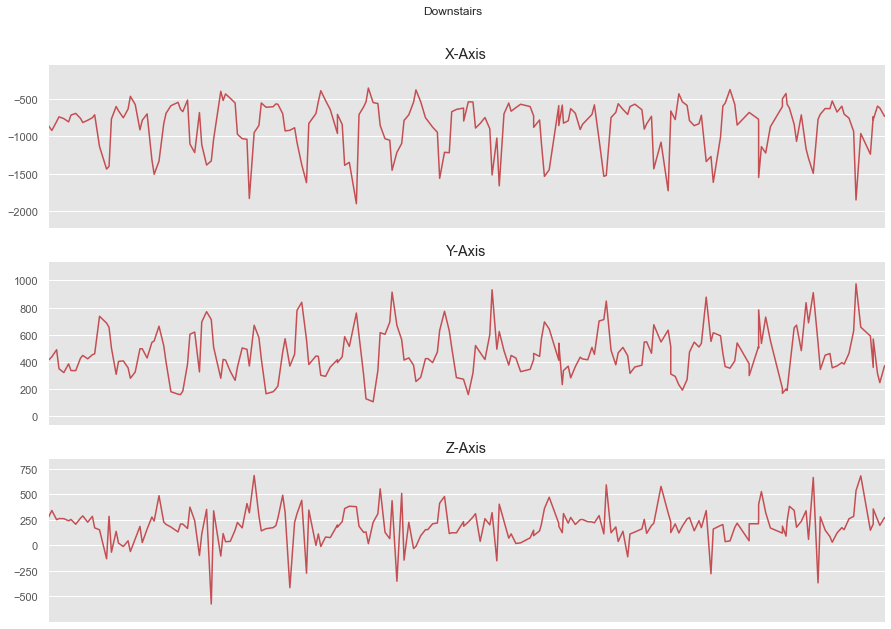

In [62]:
plot_sensor_tile_data("srinivas_downstairs_12.csv", 0)

In [123]:
downstairs_accuracy_model1 = read_and_parse_test_file('srinivas_downstairs_12.csv', model1, 0, 1)

Model : DNN
x_test shape:  (4, 240)
4 test samples
y_test shape:  (4,)

Accuracy : 0.00
[5 5 5 5]
[0 0 0 0]
Walking
Walking
Walking
Walking
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       4.0
           5       0.00      0.00      0.00       0.0

    accuracy                           0.00       4.0
   macro avg       0.00      0.00      0.00       4.0
weighted avg       0.00      0.00      0.00       4.0



In [110]:
downstairs_accuracy_model3 = read_and_parse_test_file('srinivas_downstairs_12.csv', model3, 0, 3)

Model : LSTM
x_test shape:  (4, 80, 3)
4 test samples
y_test shape:  (4,)

Accuracy : 0.25
[0 4 4 4]
[0 0 0 0]
Downstairs
Upstairs
Upstairs
Upstairs
              precision    recall  f1-score   support

           0       1.00      0.25      0.40         4
           4       0.00      0.00      0.00         0

    accuracy                           0.25         4
   macro avg       0.50      0.12      0.20         4
weighted avg       1.00      0.25      0.40         4



In [112]:
downstairs_accuracy_model2 = read_and_parse_test_file('srinivas_downstairs_12.csv', model21, 0, 2)

Model : CNN
x_test shape:  (4, 80, 3, 1)
4 test samples
y_test shape:  (4,)

Accuracy : 0.00
[5 5 5 5]
[0 0 0 0]
Walking
Walking
Walking
Walking
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       4.0
           5       0.00      0.00      0.00       0.0

    accuracy                           0.00       4.0
   macro avg       0.00      0.00      0.00       4.0
weighted avg       0.00      0.00      0.00       4.0



Testing of walking activity using different models

In [45]:
walking_accuracy_model3 = read_and_parse_test_file('shreya_walking.csv', model3, 5, 3)

Model : LSTM
x_test shape:  (56, 80, 3)
56 test samples
y_test shape:  (56,)

Accuracy : 0.25
[4 4 4 1 4 4 4 5 5 4 5 4 5 4 4 4 5 4 5 4 5 5 4 4 4 4 5 1 4 5 5 5 2 4 4 1 4
 4 4 4 5 4 4 1 2 2 4 1 4 0 4 2 2 5 0 4]
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
Upstairs
Upstairs
Upstairs
Jogging
Upstairs
Upstairs
Upstairs
Walking
Walking
Upstairs
Walking
Upstairs
Walking
Upstairs
Upstairs
Upstairs
Walking
Upstairs
Walking
Upstairs
Walking
Walking
Upstairs
Upstairs
Upstairs
Upstairs
Walking
Jogging
Upstairs
Walking
Walking
Walking
Sitting
Upstairs
Upstairs
Jogging
Upstairs
Upstairs
Upstairs
Upstairs
Walking
Upstairs
Upstairs
Jogging
Sitting
Sitting
Upstairs
Jogging
Upstairs
Downstairs
Upstairs
Sitting
Sitting
Walking
Downstairs
Upstairs
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.00      0.00      0.00         0
           2       0.00      

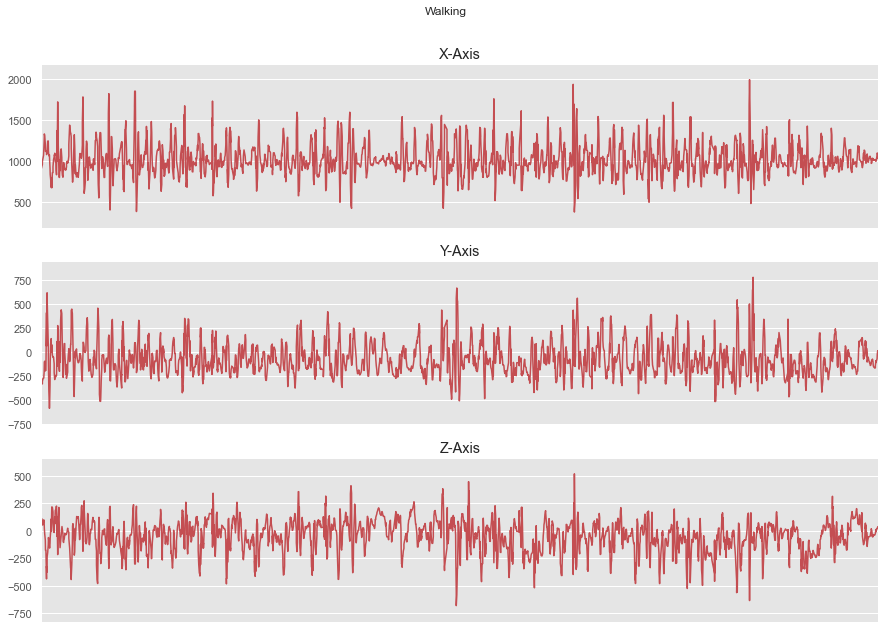

In [61]:
plot_sensor_tile_data("shreya_walking.csv", 5)

In [46]:
walking_accuracy_model2 = read_and_parse_test_file('shreya_walking.csv', model2, 5, 2)

Model : CNN
x_test shape:  (56, 80, 3, 1)
56 test samples
y_test shape:  (56,)

Accuracy : 0.02
[4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 2 4 2 4 4 4 4 4 4 4 4 4 4 5
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 2 4 2 2]
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Sitting
Sitting
Upstairs
Sitting
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Walking
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Sitting
Upstairs
Sitting
Sitting
              precision    recall  f1-score   support

           2       0.00      0.00      0.00         0
           4       0.00      0.00      0.00         0
           5  

In [93]:
walking_accuracy_model1 = read_and_parse_test_file('shreya_walking.csv', model1, 5, 1)

Model : DNN
x_test shape:  (56, 240)
56 test samples
y_test shape:  (56,)

Accuracy : 0.00
[4 2 4 4 4 4 4 4 4 4 4 4 4 4 2 4 4 4 1 4 4 2 2 2 2 2 4 4 2 4 4 2 4 2 4 4 4
 4 4 4 2 2 2 2 4 4 1 4 4 2 4 2 2 2 2 4]
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
Upstairs
Sitting
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Sitting
Upstairs
Upstairs
Upstairs
Jogging
Upstairs
Upstairs
Sitting
Sitting
Sitting
Sitting
Sitting
Upstairs
Upstairs
Sitting
Upstairs
Upstairs
Sitting
Upstairs
Sitting
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Sitting
Sitting
Sitting
Sitting
Upstairs
Upstairs
Jogging
Upstairs
Upstairs
Sitting
Upstairs
Sitting
Sitting
Sitting
Sitting
Upstairs
              precision    recall  f1-score   support

           1       0.00      0.00      0.00       0.0
           2       0.00      0.00      0.00       0.0
           4       0.00      0.00

In [48]:
walking_accuracy_model2 = read_and_parse_test_file('shreya_walking.csv', model21, 5, 2)

Model : CNN
x_test shape:  (56, 80, 3, 1)
56 test samples
y_test shape:  (56,)

Accuracy : 0.12
[2 5 5 4 4 4 5 4 5 4 4 4 4 2 2 2 4 2 4 4 4 4 4 2 2 2 4 4 2 5 4 2 4 2 4 5 4
 4 4 4 2 4 4 4 4 4 4 1 4 2 4 4 2 5 2 2]
[5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5]
Sitting
Walking
Walking
Upstairs
Upstairs
Upstairs
Walking
Upstairs
Walking
Upstairs
Upstairs
Upstairs
Upstairs
Sitting
Sitting
Sitting
Upstairs
Sitting
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Sitting
Sitting
Sitting
Upstairs
Upstairs
Sitting
Walking
Upstairs
Sitting
Upstairs
Sitting
Upstairs
Walking
Upstairs
Upstairs
Upstairs
Upstairs
Sitting
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Upstairs
Jogging
Upstairs
Sitting
Upstairs
Upstairs
Sitting
Walking
Sitting
Sitting
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.00      0.00      0.00         0
           4       0.00      0.

Sensor Tile Data KPIs - different activities

Sensor Tile Data KPIs

In [113]:
dict_accuracy = {}
dict_accuracy_downstairs = {}
dict_accuracy_jogging = {}
dict_accuracy_sitting = {}
dict_accuracy_standing = {}
dict_accuracy_upstairs = {}
dict_accuracy_walking = {}
MODELS = ['DNN', "CNN", "LSTM"]

In [114]:
dict_accuracy_downstairs[MODELS[0]] = downstairs_accuracy_model1
dict_accuracy_downstairs[MODELS[1]] = downstairs_accuracy_model2
dict_accuracy_downstairs[MODELS[2]] = downstairs_accuracy_model3
dict_accuracy_jogging[MODELS[0]] = jogging_accuracy_model1
dict_accuracy_jogging[MODELS[1]] = jogging_accuracy_model2
dict_accuracy_jogging[MODELS[2]] = jogging_accuracy_model3
dict_accuracy_sitting[MODELS[0]] = sitting_accuracy_model1
dict_accuracy_sitting[MODELS[1]] = sitting_accuracy_model2
dict_accuracy_sitting[MODELS[2]] = sitting_accuracy_model3
dict_accuracy_standing[MODELS[0]] = 0.0
dict_accuracy_standing[MODELS[1]] = 0.0
dict_accuracy_standing[MODELS[2]] = 0.0
dict_accuracy_upstairs[MODELS[0]] = upstairs_accuracy_model1
dict_accuracy_upstairs[MODELS[1]] = upstairs_accuracy_model2
dict_accuracy_upstairs[MODELS[2]] = upstairs_accuracy_model3
dict_accuracy_walking[MODELS[0]] = walking_accuracy_model1
dict_accuracy_walking[MODELS[1]] = walking_accuracy_model2
dict_accuracy_walking[MODELS[2]] = walking_accuracy_model3

dict_accuracy[LABELS[0]] = dict_accuracy_downstairs
dict_accuracy[LABELS[1]] = dict_accuracy_jogging
dict_accuracy[LABELS[2]] = dict_accuracy_sitting
dict_accuracy[LABELS[3]] = dict_accuracy_standing
dict_accuracy[LABELS[4]] = dict_accuracy_upstairs
dict_accuracy[LABELS[5]] = dict_accuracy_walking

In [115]:
dfaccuracy = pd.DataFrame(dict_accuracy)
print(dfaccuracy)

      Downstairs  Jogging  Sitting  Standing  Upstairs  Walking
DNN          0.5      0.2      1.0       0.0       0.0      0.0
CNN          0.0      0.9      1.0       0.0       0.8      0.1
LSTM         0.2      0.9      1.0       0.0       1.0      0.2
